**Python Machine Learning 2nd Edition by Sebastian Raschka, Packt Publishing Ltd. 2017**

# Model Evaluation and Hyperparameter Tuning

# Streamlining workflows with pipelines

## Loading the Breast Cancer Wisconsin dataset
 - https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

In [3]:
df[1].value_counts()  # B=benign, M=malignant

B    357
M    212
Name: 1, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

le.classes_

array(['B', 'M'], dtype=object)

In [5]:
le.transform(['M', 'B'])

array([1, 0])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,   # 80% has to be carried over into the y (Benign vs Malignent data)
                     random_state=1)

In [7]:
np.bincount(y_train)

array([285, 170])

In [8]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([285, 170]))

In [9]:
np.bincount(y_test)

array([72, 42])

In [10]:
np.unique(y_test, return_counts = True)

(array([0, 1]), array([72, 42]))

<br>
<br>

## Combining transformers and estimators in a pipeline

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='lbfgs', random_state=1))

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

print('Test Accuracy: {:.3f}'.format(pipe_lr.score(X_test, y_test)))

Test Accuracy: 0.956


<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_01.png" width="500"/>


<br>
<br>

# Using k-fold cross validation to assess model performance

## The holdout method

<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_02.png" width="500"/>

## K-fold cross-validation

<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_03.png" width="500"/>

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: {:2d}, Class dist.: {:}, Acc: {:.3f}'.format(k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


In [13]:
# Alternate way

from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print('CV accuracy scores:\n')
for k, score in enumerate(scores):
    print('Fold: {:2d}, Acc: {:.3f}'.format(k+1,score))

print('\nCV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy scores:

Fold:  1, Acc: 0.935
Fold:  2, Acc: 0.935
Fold:  3, Acc: 0.957
Fold:  4, Acc: 0.957
Fold:  5, Acc: 0.935
Fold:  6, Acc: 0.956
Fold:  7, Acc: 0.978
Fold:  8, Acc: 0.933
Fold:  9, Acc: 0.956
Fold: 10, Acc: 0.956

CV accuracy: 0.950 +/- 0.014


## Tuning hyperparameters via grid search 

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1, verbose=1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s


0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    3.2s finished


In [15]:
clf = gs.best_estimator_

print('Test accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Test accuracy: 0.974


<br>
<br>

# Performance evaluation metrics

## Reading a confusion matrix

<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch06/images/06_08.png" width="300"/>

In [16]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


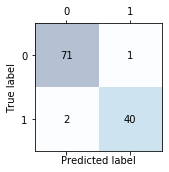

In [17]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

### Additional Note

Remember that we previously encoded the class labels so that *malignant* samples are the "postive" class (1), and *benign* samples are the "negative" class (0):

In [18]:
le.transform(['M', 'B'])

array([1, 0])

In [19]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Next, we printed the confusion matrix like so:

In [20]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Note that the (true) class 0 samples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the `labels` argument like shown below:

In [21]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (true negatives) and 40 samples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 sample from class 0 as class 1 (false positive), and it predicted that 2 samples are benign although it is a malignant tumor (false negatives).

<br>
<br>